In [1]:
import os
import pydicom as dicom
ROOT = '/srv/gevaertlab/data/pritam_CRC_Data/T2'
def find_leaves_t2(root):
    lst = []
    for r,c,f in os.walk(root):
        if len(c)==0:
            lst.append(r)
    return lst

def map_t2_vols(root):
    folders = find_leaves_t2(root)
    print(len(folders))
    t2_dict = {}
    lines = ['pid_date'+';'+'path'+'\n']
    for folder in folders:
        files = [f for f in os.listdir(folder) if f.endswith('dcm')]
        img = dicom.read_file(os.path.join(folder,files[0]))
        pid = str(img.PatientName)[3:].strip()
        t2_dict[pid+'_'+img.StudyDate] = folder
        lines.append(';'.join([pid+'_'+img.StudyDate, folder])+'\n')
    with open('t2_annos.csv','w')as fp:
        fp.writelines(lines)
    return t2_dict

t2_dict = map_t2_vols(ROOT)

223


In [2]:
import pandas as pd
df = pd.read_csv('t2_annos.csv', sep=';')
df = df.drop_duplicates()
df.to_csv('t2_annos.csv',sep=";")

In [8]:
DWI_ROOT = '/srv/gevaertlab/data/pritam_CRC_Data/DWI'
def find_leaves_dwi(root):
    lst = []
    for r,c,f in os.walk(root):
        if len(c)==0:
            lst.append(r)
    return lst

def map_dwi_vols(root):
    folders = find_leaves_dwi(root)
    dwi_dict = {}
    lines = ['pid_date'+';'+'path'+'\n']
    for folder in folders:
        files = [f for f in os.listdir(folder) if f.endswith('dcm')]
        img = dicom.read_file(os.path.join(folder,files[0]))
        pid = str(img.PatientName)[3:].strip()
        lines.append(';'.join([pid+'_'+img.StudyDate, os.path.dirname(folder)])+'\n')
        dwi_dict[pid+'_'+img.StudyDate] = os.path.dirname(folder)
    with open('dwi_annos.csv','w')as fp:
        fp.writelines(lines)
    return dwi_dict
dwi_dict = map_dwi_vols(DWI_ROOT)
df = pd.read_csv('dwi_annos.csv',sep=";")
df = df.drop_duplicates()
df.to_csv('dwi_annos.csv',sep=";")

In [9]:
df.shape

(249, 2)

In [10]:
df.shape

(249, 2)

In [12]:
root = '/srv/gevaertlab/data/pritam_CRC_Data/roi_t2'
for f in os.listdir(root):
    roi = dicom.read_file(os.path.join(root,f))
    pid = str(roi.PatientName)[3:].strip()
    study_date = roi.StudyDate
    os.rename(os.path.join(root,f), os.path.join(root,str(pid)+'_'+str(study_date)+'.dcm'))

In [14]:
# %load full_process_parallel.py
import os
import pydicom as dicom
import numpy as np
import pandas as pd
import datetime
from multiprocessing import Pool
from matplotlib import path
import imageio as imio
from matplotlib import colors as color
from scipy.io import savemat
from scipy.ndimage import map_coordinates
t2_annos = './t2_annos.csv'
dwi_annos = './dwi_annos.csv'
roi_path = '/srv/gevaertlab/data/pritam_CRC_Data/roi_t2'
overview_file = './LeuvenCohort_new.xlsx'
t2_pre_save_path = '/srv/gevaertlab/data/pritam_CRC_Data/processed_t2/pre'
t2_post_save_path = '/srv/gevaertlab/data/pritam_CRC_Data/processed_t2/post'
dwi_pre_save_path = '/srv/gevaertlab/data/pritam_CRC_Data/processed_dwi/pre'
dwi_post_save_path = '/srv/gevaertlab/data/pritam_CRC_Data/processed_dwi/post'
adc_pre_save_path = '/srv/gevaertlab/data/pritam_CRC_Data/processed_adc/pre'
adc_post_save_path = '/srv/gevaertlab/data/pritam_CRC_Data/processed_adc/post'
mask_pre_save_path = '/srv/gevaertlab/data/pritam_CRC_Data/processed_mask/pre'
mask_post_save_path = '/srv/gevaertlab/data/pritam_CRC_Data/processed_mask/post'
test_images_dest = '/srv/gevaertlab/data/pritam_CRC_test/test_images'
pats = ['54','76','68','91','39','85','72']

def normalize(vol):
    return (vol-vol.min())/(vol.max()-vol.min())

def blend(vol,mask,alpha):
    vol = normalize(vol)
    color_vol = np.stack([vol,vol,vol],axis=3)
    color_mask = np.stack([np.zeros_like(mask),mask,np.zeros_like(mask)],axis =3)
    vol_hsv = color.rgb_to_hsv(color_vol)
    color_mask_hsv = color.rgb_to_hsv(color_mask)
    vol_hsv[..., 0] = color_mask_hsv[..., 0]
    vol_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    vol_masked = color.hsv_to_rgb(vol_hsv)
    return normalize(vol_masked)


def load_series(path):
    slices = [filename for filename in os.listdir(path) if (filename.endswith('.dcm')) and ('Mask' not in filename)]
    images = [dicom.read_file(os.path.join(path,file)) for file in slices]
    images = sorted(images,key=lambda x: x.InstanceNumber)
    return images

def load_pixel_vol(vol,axis):
    return np.stack([image.pixel_array for image in vol],axis=axis)

def load_dwi_vols(dwi_path):
    return [load_series(os.path.join(dwi_path,s)) for s in os.listdir(dwi_path) if '800' not in s]
    
def get_transform_matrix(sorted_images):
    N = len(sorted_images)
    if N<2:
        return None
    T1 = np.array(sorted_images[0].ImagePositionPatient).astype(np.float32)
    TN = np.array(sorted_images[len(sorted_images)-1].ImagePositionPatient).astype(np.float32)
    cosines = sorted_images[0].ImageOrientationPatient
    delta_r = sorted_images[0].PixelSpacing[0]
    delta_c = sorted_images[0].PixelSpacing[1]
    F = np.array([[cosines[3],cosines[0]],[cosines[4],cosines[1]],[cosines[5],cosines[2]]])
    transform = np.zeros([4,4])
    transform[0:3,0]= F[:,0]*delta_r
    transform[0:3,1] = F[:,1]*delta_c
    transform[0:3,2] = ((T1-TN)/(1-N)).T
    transform[0:3,3] = T1.T
    transform[3,3]=1
    return transform


def interpolate_vols(dicom_vols,target):
    flag = True
    if len(dicom_vols)<2:
        flag = False
        return flag, None
    consistent, vol_list,dwi_transform = checkconsistency(dicom_vols)
    if not consistent:
        if len(vol_list)<2:
            print('Could not find enough consistent volumes...Skipping patient', dicom_vols[0][0].PatientName)
            flag = False
            return flag, None
        dicom_vols = vol_list    
    vols = np.stack([load_pixel_vol(vol,0) for vol in dicom_vols],axis =0).astype(np.float32)
    bvals = np.array([float(vol[0].DiffusionBValue) for vol in dicom_vols])
    vols[np.where(vols<1)]=0.1 #to avoid log(0)
    logvols = np.log(vols)
    extended_b = np.stack([bvals,np.ones_like(bvals)],axis=0)
    A = np.tensordot(np.linalg.inv(np.dot(extended_b,extended_b.T)),np.tensordot(extended_b,logvols,axes=([1],[0])),axes=([0],[0]))
    adc = -1*A[0,...]
    new_vol = np.tensordot(A,np.array([target,1]),axes = ([0],[0]))
    target_vol = np.exp(new_vol)
    target_vol = np.stack([target_vol[i,...] for i in range(target_vol.shape[0])],axis=2)
    adc = np.stack([adc[i,...] for i in range(adc.shape[0])],axis =2)
    return target_vol, adc, dwi_transform

def align_vols(t2_vol, dwi_vol, adc_vol, dwi_transform):
    t2_transform = get_transform_matrix(t2_vol)
    t2_pixel_vol = load_pixel_vol(t2_vol,2)
    t2_coords = np.array(np.where(t2_pixel_vol>=0))
    t2_coords_in_dwi_frame = np.dot( np.linalg.inv(dwi_transform)@ t2_transform ,np.vstack([t2_coords,np.ones([1,t2_coords.shape[1]])]))[0:3,:] 
    interpolated_adc_vol = map_coordinates(adc_vol,t2_coords_in_dwi_frame,order =1,mode='constant',cval=0)
    transformed_adc_vol = np.reshape(interpolated_adc_vol,t2_pixel_vol.shape)
    interpolated_dwi_vol = map_coordinates(dwi_vol,t2_coords_in_dwi_frame,order =1,mode='constant',cval=0)
    transformed_dwi_vol = np.reshape(interpolated_dwi_vol,t2_pixel_vol.shape)
    return transformed_dwi_vol, transformed_adc_vol




def checkconsistency(dicom_vols):
    consistency = True
    full_length =len(dicom_vols)
    lengths={}
    for vol in dicom_vols:
        if len(vol) not in lengths:
            lengths[len(vol)]=[vol]
        else:
            lengths[len(vol)]+= [vol]
    indices_list = sorted([lengths[key] for key in lengths.keys()],key = lambda x: len(x),reverse = True)
    max_list = indices_list[0]
    dicom_vols = max_list
    orientations = {}
    for vol in dicom_vols:
        if str(vol[0].ImageOrientationPatient) not in orientations:
            orientations[str(vol[0].ImageOrientationPatient)]=[vol]
        else:
            orientations[str(vol[0].ImageOrientationPatient)]+=[vol]
    indices_list = sorted([orientations[key] for key in orientations.keys()],key = lambda x: len(x),reverse = True)
    max_list = indices_list[0]
    if len(max_list)!= full_length:
        consistency = False
    dwi_transform = get_transform_matrix(max_list[0]) 
    return consistency, max_list, dwi_transform

def get_roi_info(roi_file):
    mask_info = dicom.read_file(roi_file)
    contour_dict = {}
    for i in range(len(mask_info.ROIContourSequence)):
        contour_dict['ROIContourSequence'+str(i)] = {}
        for j in range(len(mask_info.ROIContourSequence[i].ContourSequence)):
            contour_data = mask_info.ROIContourSequence[i].ContourSequence[j].ContourData
            coords = [[contour_data[3*i],contour_data[3*i+1],contour_data[3*i+2]] for i in range(int(len(contour_data)/3))] 
            sop_uid = mask_info.ROIContourSequence[i].ContourSequence[j].ContourImageSequence[0].ReferencedSOPInstanceUID
            contour_dict['ROIContourSequence'+str(i)][sop_uid] = coords
    return contour_dict

def process_contours(contour_dict, ref_vol):
    slice_instance_dict = {}
    for i in range(len(ref_vol)):
        slice_instance_dict[ref_vol[i].SOPInstanceUID]=i
    voxel_2_world = get_transform_matrix(ref_vol)
    x_len = ref_vol[0].pixel_array.shape[0]
    y_len = ref_vol[0].pixel_array.shape[1]
    z_len = len(ref_vol)
    slice_grid = np.array(np.where(np.zeros([x_len,y_len])==0)).T
    new_vol = np.zeros([ref_vol[0].pixel_array.shape[0],ref_vol[0].pixel_array.shape[0],len(ref_vol)])
    for roi_contour_seq in contour_dict:
        for sop_id in contour_dict[roi_contour_seq]:
            slice_to_process = slice_instance_dict[sop_id]
            coords = np.array(contour_dict[roi_contour_seq][sop_id])
            roi_t2_pixel_coords = transform_coords(np.linalg.inv(voxel_2_world),coords)
            contour_path = path.Path(roi_t2_pixel_coords[0:2,:].T,closed=True)
            new_slice = np.zeros([x_len,y_len])
            points_included = slice_grid[np.where(contour_path.contains_points(slice_grid))]
            new_slice[points_included[:,0],points_included[:,1]]=1
            new_vol[:,:,slice_to_process]=new_slice
    return new_vol

def transform_coords(t_matrix,coords):
    concat_coord = np.concatenate((coords,np.ones([coords.shape[0],1])),axis =1)
    new_coords = np.dot(t_matrix,concat_coord.T)
    return new_coords[0:3,:]


def create_verification_gifs(t2_vol, dwi_vol, adc_vol):
    t2_pixel_vol = load_pixel_vol(t2_vol,2)
    pid = str(t2_vol[0].PatientName)[3:].strip()
    study_date = t2_vol[0].StudyDate
    roi_file = os.path.join(roi_path,pid+'_'+study_date +'.dcm')
    contours = get_roi_info(roi_file)
    mask = process_contours(contours, t2_vol)
    masked_t2 = blend(t2_pixel_vol,mask,0.2)
    masked_adc = blend(adc_vol, mask,0.2)
    combined_images = np.ones([masked_t2.shape[0],2*masked_t2.shape[1]+20,masked_t2.shape[2],3])
    combined_images[:,0:masked_t2.shape[1],...] = masked_t2
    combined_images[:,masked_t2.shape[0]+20:,...] = masked_adc
    combined_images = [combined_images[:,:,i,:] for i in range(combined_images.shape[2])]
    if not os.path.exists(test_images_dest):
        os.makedirs(test_images_dest)
    imio.mimwrite(os.path.join(test_images_dest,str(t2_vol[0].PatientName)+'_'+str(t2_vol[0].StudyDate)+'.gif'),combined_images, duration =0.5, subrectangles=True)
    return mask



def process(paths):
    t2_path = paths[0]
    dwi_path = paths[1]
    dwi_vols = load_dwi_vols(dwi_path)
    t2_vol = load_series(t2_path)
    target_dwi_vol,adc, dwi_transform = interpolate_vols(dwi_vols,800)
    aligned_dwi_vol,aligned_adc = align_vols(t2_vol,target_dwi_vol,adc,dwi_transform)
    mask = create_verification_gifs(t2_vol,aligned_dwi_vol,aligned_adc)
    return t2_vol, aligned_dwi_vol, aligned_adc, mask


def process_row(row):
    index = row[0]
    row = row[1]
    if str(index) in pats:
        return 
    t2_date_pre = row['Date MRI PRE'].strftime('%Y%m%d')
    t2_date_post = row['Date MRI POST'].strftime('%Y%m%d')
    dwi_date_pre = row['Date DWI PRE'].strftime('%Y%m%d')
    dwi_date_post = t2_date_pre
    t2_anno = pd.read_csv(t2_annos, sep= ';')
    dwi_anno = pd.read_csv(dwi_annos, sep =';')
    t2_pre_path = t2_anno[t2_anno.pid_date == str(index)+'_'+t2_date_pre].path.values[0]
    t2_post_path = t2_anno[t2_anno.pid_date == str(index)+'_'+t2_date_post].path.values[0]
    dwi_pre_path = dwi_anno[dwi_anno.pid_date == str(index)+'_'+t2_date_pre].path.values[0]
    dwi_post_path = dwi_anno[dwi_anno.pid_date == str(index)+'_'+t2_date_pre].path.values[0]
    t2_vol_pre, dwi_vol_pre, adc_vol_pre, mask_pre = process((t2_pre_path,dwi_pre_path))
    t2_vol_post, dwi_vol_post, adc_vol_post, mask_post = process((t2_post_path,dwi_post_path))
    if not os.path.exists(t2_pre_save_path):
        os.makedirs(t2_pre_save_path)
    savemat(os.path.join(t2_pre_save_path,str(index)),{'img':load_pixel_vol(t2_vol_pre,2)})
    if not os.path.exists(t2_post_save_path):
        os.makedirs(t2_post_save_path)
    savemat(os.path.join(t2_post_save_path,str(index)),{'img':load_pixel_vol(t2_vol_post,2)})
    if not os.path.exists(dwi_pre_save_path):
        os.makedirs(dwi_pre_save_path)
    savemat(os.path.join(dwi_pre_save_path,str(index)),{'img':dwi_vol_pre}) 
    if not os.path.exists(dwi_post_save_path):
        os.makedirs(dwi_post_save_path)
    savemat(os.path.join(dwi_post_save_path,str(index)),{'img':dwi_vol_post})
    if not os.path.exists(adc_pre_save_path):
        os.makedirs(adc_pre_save_path)
    savemat(os.path.join(adc_pre_save_path,str(index)),{'img':adc_vol_pre})
    if not os.path.exists(adc_post_save_path):
        os.makedirs(adc_post_save_path)
    savemat(os.path.join(adc_post_save_path,str(index)),{'img':adc_vol_post})
    if not os.path.exists(mask_pre_save_path):
        os.makedirs(mask_pre_save_path)
    savemat(os.path.join(mask_pre_save_path,str(index)),{'img':mask_pre})
    if not os.path.exists(mask_post_save_path):
        os.makedirs(mask_post_save_path)
    savemat(os.path.join(mask_post_save_path,str(index)),{'img':mask_post})
    print('Finished processing patient ', index)

if __name__=="__main__":
    overview = pd.read_excel(overview_file,sheet_name="Blad1")
    rows = list(overview.iterrows())
    with Pool(4) as pool:
        pool.map(process_row,rows)


KeyboardInterrupt: 

In [52]:
import pandas as pd
import os
root = '/srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_post'

In [84]:
import imageio as imio
import numpy as np
from matplotlib import pyplot as plt
import pydicom as dicom
def load_series(path,target):
    files = [f for f in os.listdir(path) if f.endswith('dcm')]
    images = [dicom.read_file(os.path.join(path,f)) for f in files]
    for i in images:
        assert i[0x2001,0x1003].value - images[0][0x2001,0x1003].value < 0.01
        if (i[0x2001,0x1003].value - target)>0.01:
            print('wrong b-value : skipping patient ',p)
            print('target, read_value',target,i[0x2001,0x1003].value)
    images = sorted(images, key=lambda x: x.SliceLocation)
    pixel_data = [x.pixel_array for x in images]
    true_bval = images[0][0x2001,0x1003].value
    return np.stack(pixel_data,axis=0),true_bval,images[0].ImageOrientationPatient,images[0].ImagePositionPatient
def process(p):
    b0_path = os.path.join(p,'b-0')
    b800_path = os.path.join(p,'b-800')
    print('processing patient',p)
    b0_vol,true_bval1,orient1,pos1= load_series(b0_path,0.0)
    b800_vol,true_bval2,orient2,pos2= load_series(b800_path,800.0)
    if (b0_vol is None) or (b800_vol is None):
        return
    #b0_vol = imio.mvolread(b0_path,'dicom').astype(np.float32)
    #b800_vol = imio.mvolread(b800_path,'dicom').astype(np.float32)
    assert orient1 == orient2
    assert pos1 == pos2
    b0_vol = b0_vol.astype(np.float32)
    b800_vol = b800_vol.astype(np.float32)
    if (b0_vol.shape != b800_vol.shape):
        print('wrong shape: skipping patient',p)
        return
    b0_vol[np.where(b0_vol == 0)] = 0.1
    b800_vol[np.where(b800_vol ==0)] =0.1
    adc_map = (-1/(true_bval2-true_bval1))*np.log(b800_vol/b0_vol) 
#    adc_map[np.where((b0_vol==0.1)&(b800_vol==0.1))]=adc_map.min()
#    return adc_map
    np.save(os.path.join(p,'adc.npy'),adc_map)
    print('finished processing')
    
   
    

for p in os.listdir(root):
    process(os.path.join(root,p))

In [55]:
struct_info = dicom.read_file(os.path.join(root,'0002/rtstruct.dcm'))

In [56]:
struct_info

(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 2.25.309683376258783523723960291260033693343
(0008, 0020) Study Date                          DA: '20090304'
(0008, 0021) Series Date                         DA: '20090304'
(0008, 0030) Study Time                          TM: '094636.000'
(0008, 0031) Series Time                         TM: '101445.210'
(0008, 0050) Accession Number                    SH: '3759217.01'
(0008, 0060) Modality                            CS: 'RTSTRUCT'
(0008, 0070) Manufacturer                        LO: 'UMCU, RADTH'
(0008, 0080) Institution Name                    LO: 'UMC Utrecht'
(0008, 0081) Institution Address                 ST: 'Heidelberglaan 100,3584 CX Utrecht,The Netherlands'
(0008, 0090) Referring Physician's Name          PN: 'unknown'
(0008, 1010) Station Name                        SH: 'kulta.azu.nl'
(0008, 1030) Study Description                   LO: 'MRI BEKKE

In [58]:
alternate_struct = dicom.read_file('/srv/gevaertlab/data/CRC_Data/CRC_Validation_T2/T2_time2/umcudata/0002/dicom/rtstruct.dcm')
alternate_struct

(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 2.25.328160963502219002695728952836794303298
(0008, 0020) Study Date                          DA: '20090304'
(0008, 0021) Series Date                         DA: '20090304'
(0008, 0030) Study Time                          TM: '094636.000'
(0008, 0031) Series Time                         TM: '100703.930'
(0008, 0050) Accession Number                    SH: '3759217.01'
(0008, 0060) Modality                            CS: 'RTSTRUCT'
(0008, 0070) Manufacturer                        LO: 'Radth'
(0008, 0080) Institution Name                    LO: 'UMC Utrecht'
(0008, 0081) Institution Address                 ST: 'Heidelberglaan 100,3584 CX Utrecht,The Netherlands'
(0008, 0090) Referring Physician's Name          PN: 'unknown'
(0008, 1010) Station Name                        SH: 'kulta.azu.nl'
(0008, 1030) Study Description                   LO: 'MRI BEKKEN'
(00

In [5]:
from matplotlib import colors as color
from matplotlib import path
from multiprocessing import Pool
time = 'post'
root = '/srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_'+time

def load_collection(path):
    files = [f for f in os.listdir(path) if f.endswith('dcm')]
    images = [dicom.read_file(os.path.join(path,f)) for f in files]
    images = sorted(images, key=lambda x: x.SliceLocation)
    return images

def get_transform_matrix(sorted_images):
    N = len(sorted_images)
    if N<2:
        return None
    T1 = np.array(sorted_images[0].ImagePositionPatient).astype(np.float32)
    TN = np.array(sorted_images[len(sorted_images)-1].ImagePositionPatient).astype(np.float32)
    cosines = sorted_images[0].ImageOrientationPatient
    delta_r = sorted_images[0].PixelSpacing[0]
    delta_c = sorted_images[0].PixelSpacing[1]
    F = np.array([[cosines[3],cosines[0]],[cosines[4],cosines[1]],[cosines[5],cosines[2]]])
    transform = np.zeros([4,4])
    transform[0:3,0]= F[:,0]*delta_r
    transform[0:3,1] = F[:,1]*delta_c
    transform[0:3,2] = ((T1-TN)/(1-N)).T
    transform[0:3,3] = T1.T
    transform[3,3]=1
    return transform

def transform_coords(t_matrix,coords):
    concat_coord = np.concatenate((coords,np.ones([coords.shape[0],1])),axis =1)
    new_coords = np.dot(t_matrix,concat_coord.T)
    return new_coords[0:3,:]

def get_roi_info(mask_info):
    #mask_info = dicom.read_file(roi_file)
    contour_dict = {}
    for i in range(len(mask_info.ROIContourSequence)):
        contour_dict['ROIContourSequence'+str(i)] = {}
        for j in range(len(mask_info.ROIContourSequence[i].ContourSequence)):
            contour_data = mask_info.ROIContourSequence[i].ContourSequence[j].ContourData
            coords = [[contour_data[3*i],contour_data[3*i+1],contour_data[3*i+2]] for i in range(int(len(contour_data)/3))] 
            sop_uid = mask_info.ROIContourSequence[i].ContourSequence[j].ContourImageSequence[0].ReferencedSOPInstanceUID
            contour_dict['ROIContourSequence'+str(i)][sop_uid] = coords
    return contour_dict

#def process_contours(contour_dict, ref_vol):
#    slice_instance_dict = {}
#    for i in range(len(ref_vol)):
#        slice_instance_dict[ref_vol[i].SOPInstanceUID]=i
#    voxel_2_world = get_transform_matrix(ref_vol)
#    x_len = ref_vol[0].pixel_array.shape[0]
#    y_len = ref_vol[0].pixel_array.shape[1]
#    z_len = len(ref_vol)
#    slice_grid = np.array(np.where(np.zeros([x_len,y_len])==0)).T
#    new_vol = np.zeros([ref_vol[0].pixel_array.shape[0],ref_vol[0].pixel_array.shape[1],len(ref_vol)])
#    for roi_contour_seq in contour_dict:
#        for sop_id in contour_dict[roi_contour_seq]:
#            try:
#                slice_to_process = slice_instance_dict[sop_id]
#            except KeyError:
#                print('Did not find slice...aborting')
#                return None
#            coords = np.array(contour_dict[roi_contour_seq][sop_id])
#            roi_t2_pixel_coords = transform_coords(np.linalg.inv(voxel_2_world),coords)
#            contour_path = path.Path(roi_t2_pixel_coords[0:2,:].T,closed=True)
#            new_slice = np.zeros([x_len,y_len])
#            points_included = slice_grid[np.where(contour_path.contains_points(slice_grid))]
#            new_slice[points_included[:,0],points_included[:,1]]=1
#            new_vol[:,:,slice_to_process]=new_slice
#    return new_vol

def process_contours(contour_dict,ref_vol):
#    print('Trying alternate process contours for patient:', ref_vol[0].PatientName)
    voxel_2_world = get_transform_matrix(ref_vol)
    x_len = ref_vol[0].pixel_array.shape[0]
    y_len = ref_vol[0].pixel_array.shape[1]
    z_len = len(ref_vol)
    slice_grid = np.array(np.where(np.zeros([x_len,y_len])==0)).T
    new_vol = np.zeros([ref_vol[0].pixel_array.shape[0],ref_vol[0].pixel_array.shape[1],len(ref_vol)])
    contour_points = []
    for roi_contour_seq in contour_dict:
        for sop_id in contour_dict[roi_contour_seq]:
            coords = np.array(contour_dict[roi_contour_seq][sop_id])
            roi_t2_pixel_coords = transform_coords(np.linalg.inv(voxel_2_world),coords)
            #print(roi_t2_pixel_coords.shape)
            slice_to_process = np.unique(np.round(roi_t2_pixel_coords[2:]).astype(np.int32))
#            print(slice_to_process)
            if slice_to_process.shape[0]>1:
                print('Slices to process:', slice_to_process)
                return None
            contour_path = path.Path(roi_t2_pixel_coords[0:2,:].T,closed=True)
            contour_points.append(roi_t2_pixel_coords)
            new_slice = np.zeros([x_len,y_len,1])
            points_included = slice_grid[np.where(contour_path.contains_points(slice_grid))]
            new_slice[points_included[:,0],points_included[:,1],np.zeros_like(points_included[:,1])]=1
#            print(new_slice.shape, new_vol[:,:,slice_to_process].shape)
            new_vol[:,:,slice_to_process]=new_slice
    #print(np.concatenate(contour_points,axis=0).shape)
    return new_vol,contour_points


def normalize(vol):
    return (vol-vol.min())/(vol.max()-vol.min())

def blend(vol,mask,alpha):
    vol = normalize(vol)
    color_vol = np.stack([vol,vol,vol],axis=3)
    color_mask = np.stack([mask,np.zeros_like(mask),np.zeros_like(mask)],axis =3)
    vol_hsv = color.rgb_to_hsv(color_vol)
    color_mask_hsv = color.rgb_to_hsv(color_mask)
    vol_hsv[..., 0] = color_mask_hsv[..., 0]
    vol_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    vol_masked = color.hsv_to_rgb(vol_hsv)
    return normalize(vol_masked)

def map_dwi_roi(path):
    files = [f for f in os.listdir(path) if f.endswith('dcm')]
    struct_info = dicom.read_file(os.path.join(path,files[0]))
    contour_dict = get_roi_info(struct_info)
    ref_vol = load_collection(os.path.join(path,'b-800'))
    mask,paths = process_contours(contour_dict,ref_vol)
    adc = np.load(os.path.join(path,'adc.npy'))
    adc = np.stack([adc[i,...] for i in range(adc.shape[0])],axis=2)
    masked_adc = blend(adc,mask,0.3)
    dest_dir = '/srv/gevaertlab/data/pritam_CRC_test/adc_validation/'+time
    print('processing:',ref_vol[0].PatientID)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    imio.mimwrite(os.path.join(dest_dir,ref_vol[0].PatientID)+'.gif',[masked_adc[:,:,i,:] for i in range(masked_adc.shape[2])])
    
                                    
#for p in os.listdir(root):
#    map_dwi_roi(os.path.join(root,p))
#patients = [os.path.join(root,x) for x in os.listdir(root)]
#with Pool(5) as pool:
#    pool.map(map_dwi_roi,patients)


In [88]:
adc = normalize(process(os.path.join(root,'0002')))

processing patient /srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_post/0002


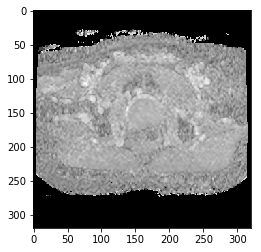

In [89]:
plt.imshow(adc[11,...],cmap='gray')

In [93]:
struct_info.SOPClassUID

'1.2.840.10008.5.1.4.1.1.481.3'

In [3]:
import os
time = 'post'
t2_time = {'pre':'T2_time1','post':'T2_time2'}
t2_root = '/srv/gevaertlab/data/CRC_Data/CRC_Validation_T2/'+t2_time[time]+'/umcudata'

def load_t2_collection(path):
    files = [f for f in os.listdir(path) if f.endswith('dcm')]
    images = [dicom.read_file(os.path.join(path,f)) for f in files]
    i=0
    while i<len(images):
        if images[i].SOPClassUID == '1.2.840.10008.5.1.4.1.1.481.3':
            roi_struct = images.pop(i)
            i-=1
        i+=1
    images = sorted(images, key=lambda x: x.SliceLocation)
    return images, roi_struct

#images,struct = load_t2_collection(t2_root+'/'+'0002/dicom')
#struct

In [6]:
import os
import pydicom as dicom
from matplotlib import path
from matplotlib import colors as color
from multiprocessing import Pool
import numpy as np
from scipy.ndimage import map_coordinates
import imageio as imio
from skimage.draw import polygon_perimeter
time = 'post'
root = '/srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_'+time
t2_root = '/srv/gevaertlab/data/pritam_CRC_Data/missing_t2_validation'

def load_pixel_vol(vol,axis):
    return np.stack([image.pixel_array for image in vol],axis=axis)

def align_vols(t2_vol, adc_vol, dwi_transform):
    t2_transform = get_transform_matrix(t2_vol)
    t2_pixel_vol = load_pixel_vol(t2_vol,2)
    t2_coords = np.array(np.where(t2_pixel_vol>=0))
    t2_coords_in_dwi_frame = np.dot( np.linalg.inv(dwi_transform)@ t2_transform ,np.vstack([t2_coords,np.ones([1,t2_coords.shape[1]])]))[0:3,:] 
    interpolated_adc_vol = map_coordinates(adc_vol,t2_coords_in_dwi_frame,order =1,mode='constant',cval=0)
    transformed_adc_vol = np.reshape(interpolated_adc_vol,t2_pixel_vol.shape)
    return transformed_adc_vol

def new_blend(vol,contours):
    vol = normalize(vol)
    color_vol = np.stack([vol,vol,vol],axis=3)
    for contour in contours:
        slice_num = np.round(contour[2][0]).astype(np.int16)
        #print(slice_num)
        rr,cc = polygon_perimeter(contour[0],contour[1])
        slice_numbers = slice_num*np.ones_like(rr)
        #print(rr.shape,cc.shape,slice_numbers.shape)
        color_vol[rr,cc,slice_numbers,:] =[1,0,0]

    #print(np.where(color_vol==1))
    return color_vol
    

def map_t2_dwi_roi(paths):
    t2_path = paths[0]
    dwi_path = paths[1]
    if not os.path.exists(t2_path):
        print('missing patient t2:', os.path.basename(dwi_path))
        return
    t2_vol,t2_roi = load_t2_collection(t2_path)
    contour_dict = get_roi_info(t2_roi)
    dwi_vol = load_collection(os.path.join(dwi_path,'b-800'))
    mask,contours = process_contours(contour_dict,t2_vol)
    np.save(os.path.join(dwi_path,'mask.npy'),mask)
    adc = np.load(os.path.join(dwi_path,'adc.npy'))
    adc = np.stack([adc[i,...] for i in range(adc.shape[0])],axis=2)
    dwi_transform = get_transform_matrix(dwi_vol)
    #print('starting alignment')
    aligned_adc = align_vols(t2_vol,adc,dwi_transform)
    np.save(os.path.join(dwi_path,'aligned_adc.npy'),aligned_adc)
    #print('starting blending')
    masked_adc = new_blend(aligned_adc,contours)
    masked_t2 = new_blend(load_pixel_vol(t2_vol,2),contours)
    #print('finished blending', masked_t2.shape,masked_adc.shape)
    combined_images = np.ones([masked_t2.shape[0],2*masked_t2.shape[1]+20,masked_t2.shape[2],3])
    combined_images[:,0:masked_t2.shape[1],...] = masked_t2
    combined_images[:,masked_t2.shape[0]+20:,...] = masked_adc
    combined_images = [combined_images[:,:,i,:] for i in range(combined_images.shape[2])]
    dest_dir = '/srv/gevaertlab/data/pritam_CRC_test/missing_t2_validation/'+time
    print('processing:',dwi_vol[0].PatientID)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    imio.mimwrite(os.path.join(dest_dir,dwi_vol[0].PatientID)+'.gif',combined_images)
    

dwi_paths = [os.path.join(root,x) for x in os.listdir(t2_root)]
t2_paths = [t2_root+'/'+x+'/dicom' for x in os.listdir(t2_root)]
paths = zip(t2_paths,dwi_paths)
#for p in paths:
#    map_t2_dwi_roi(p)
with Pool(10) as pool:
    pool.map(map_t2_dwi_roi,paths)

processing: 0019


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


processing: 0004


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


processing: 0010


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [4]:
dest_dir = '/srv/gevaertlab/data/pritam_CRC_test/adc_validation_t2_rois/'+time
patients_done = [f[:-4] for f in os.listdir(dest_dir)]
patients_done

['0008',
 '0040',
 '0045',
 '0010',
 '0053',
 '0012',
 '0023',
 '0037',
 '0065',
 '0017',
 '0013',
 '0059',
 '0052',
 '0043',
 '0019',
 '0050',
 '0051',
 '0044',
 '0048',
 '0011',
 '0041',
 '0047',
 '0025',
 '0061',
 '0056',
 '0046',
 '0057',
 '0035',
 '0016',
 '0038',
 '0015',
 '0004',
 '0002',
 '0009',
 '0014',
 '0042',
 '0003',
 '0054',
 '0064',
 '0007',
 '0039',
 '0029',
 '0020',
 '0031',
 '0060',
 '0018',
 '0032',
 '0033',
 '0055',
 '0021',
 '0034',
 '0058']

In [5]:
missing_t2

NameError: name 'missing_t2' is not defined

In [37]:
list(paths)

[]

(-2, 2)

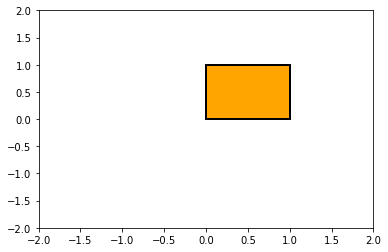

In [7]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

verts = [
    (0., 0.), # left, bottom
    (0., 1.), # left, top
    (1., 1.), # right, top
    (1., 0.), # right, bottom
    (0., 0.), # ignored
    ]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts, codes)

#fig = plt.figure()
#ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='orange', lw=2)
#ax.add_patch(patch)
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)


In [20]:
a = np.array([[2,2,4,5,6,0],[2,3,5,7,3,5],[2,4,5,6,7,2]])
np.where(a==2)

(array([0, 0, 1, 2, 2]), array([0, 1, 0, 0, 5]))

In [30]:
a[)]=1000
a

IndexError: index 5 is out of bounds for axis 0 with size 3

In [28]:
a

array([[2, 2, 4, 5, 6, 0],
       [2, 3, 5, 7, 3, 5],
       [2, 4, 5, 6, 7, 2]])

In [32]:
b = np.stack([np.array([0,0,1,2,2]),np.array([0,1,0,0,5])],axis=0)

In [35]:
a[b[0],b[1]]=1000

In [34]:
b[0]

array([0, 0, 1, 2, 2])

In [36]:
a

array([[1000, 1000,    4,    5,    6,    0],
       [1000,    3,    5,    7,    3,    5],
       [1000,    4,    5,    6,    7, 1000]])

In [48]:
4*np.ones(10)

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [3]:
import os
from multiprocessing import Pool
time = 'post'
root = '/srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_'+time
dwi_paths = [os.path.join(root,x) for x in os.listdir(root)]
import pandas as pd
import numpy as np
def avg_adc_values(path):
    try:
        adc = np.load(os.path.join(path,'aligned_adc.npy'))
        mask = np.load(os.path.join(path,'mask.npy'))
    except FileNotFoundError:
        print('missing',path)
        return np.nan
    masked_adc = mask*adc
    masked_img_roi = masked_adc[np.where(mask>=1)]
    return masked_img_roi.mean()
with Pool(10) as pool:
    avg_adc_vals = pool.map(avg_adc_values,dwi_paths)
df = pd.DataFrame({'pats':[str(int(os.path.basename(x)))+'_'+time for x in dwi_paths],'avg_adc':avg_adc_vals})
df.head()


missing /srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_post/0026
missing /srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_post/0021


,avg_adc,pats
0,0.001372,51_post
1,NaN,26_post
2,0.001464,34_post
3,0.001481,11_post
4,0.001231,40_post


In [4]:
time = 'pre'
root = '/srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_'+time
dwi_paths = [os.path.join(root,x) for x in os.listdir(root)]
import pandas as pd
def avg_adc_values(path):
    try:
        adc = np.load(os.path.join(path,'aligned_adc.npy'))
        mask = np.load(os.path.join(path,'mask.npy'))
    except FileNotFoundError:
        print('missing',path)
        return np.nan
    masked_adc = mask*adc
    masked_img_roi = masked_adc[np.where(mask>=1)]
    return masked_img_roi.mean()
with Pool(10) as pool:
    avg_adc_vals = pool.map(avg_adc_values,dwi_paths)
pre_df = pd.DataFrame({'pats':[str(int(os.path.basename(x)))+'_'+time for x in dwi_paths],'avg_adc':avg_adc_vals})
pre_df.head()

missing /srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_pre/0026
missing /srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_pre/0027
missing /srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_pre/0028


,avg_adc,pats
0,0.001101,51_pre
1,NaN,26_pre
2,0.001150,34_pre
3,0.001003,11_pre
4,0.000929,40_pre


In [5]:
df.shape,pre_df.shape

((55, 2), (55, 2))

In [6]:
full_df = df.append(pre_df,ignore_index = True)
full_df.shape

(110, 2)

In [7]:
full_df.to_csv('avg_adc_validation.csv',columns = ['pats','avg_adc'])

In [32]:
## create example Images for olivier
import os
import pydicom as dicom
from matplotlib import path
from matplotlib import colors as color
from multiprocessing import Pool
import numpy as np
from scipy.ndimage import map_coordinates
import imageio as imio
from skimage.draw import polygon_perimeter
time = 'post'
root = '/srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_'+time
t2_root = '/srv/gevaertlab/data/pritam_CRC_Data/missing_t2_validation'


def load_t2_collection(path):
    files = [f for f in os.listdir(path) if f.endswith('dcm')]
    images = [dicom.read_file(os.path.join(path,f)) for f in files]
    i=0
    while i<len(images):
        if images[i].SOPClassUID == '1.2.840.10008.5.1.4.1.1.481.3':
            roi_struct = images.pop(i)
            i-=1
        i+=1
    images = sorted(images, key=lambda x: x.SliceLocation)
    return images, roi_struct

def load_pixel_vol(vol,axis):
    return np.stack([image.pixel_array for image in vol],axis=axis)

def align_vols(t2_vol, adc_vol, dwi_transform):
    t2_transform = get_transform_matrix(t2_vol)
    t2_pixel_vol = load_pixel_vol(t2_vol,2)
    t2_coords = np.array(np.where(t2_pixel_vol>=0))
    t2_coords_in_dwi_frame = np.dot( np.linalg.inv(dwi_transform)@ t2_transform ,np.vstack([t2_coords,np.ones([1,t2_coords.shape[1]])]))[0:3,:] 
    interpolated_adc_vol = map_coordinates(adc_vol,t2_coords_in_dwi_frame,order =1,mode='constant',cval=0)
    transformed_adc_vol = np.reshape(interpolated_adc_vol,t2_pixel_vol.shape)
    return transformed_adc_vol

def new_blend(vol,contours):
    #vol = normalize(vol)
    vol = vol.astype(np.float32)
    for i in range(vol.shape[2]):
        vol[:,:,i]= normalize(vol[:,:,i])
        print(vol[:,:,i].max(),vol[:,:,i].min())
    color_vol = np.stack([vol,vol,vol],axis=3)
    for contour in contours:
        slice_num = np.round(contour[2][0]).astype(np.int16)
        #print(slice_num)
        rr,cc = polygon_perimeter(contour[0],contour[1])
        slice_numbers = slice_num*np.ones_like(rr)
        #print(rr.shape,cc.shape,slice_numbers.shape)
        color_vol[rr,cc,slice_numbers,:] =[1,0,0]

    #print(np.where(color_vol==1))
    return color_vol
    

def map_t2_dwi_roi(paths):
    t2_path = paths[0]
    dwi_path = paths[1]
    if not os.path.exists(t2_path):
        print('missing patient t2:', os.path.basename(dwi_path))
        return
    t2_vol,t2_roi = load_t2_collection(t2_path)
    contour_dict = get_roi_info(t2_roi)
    dwi_vol = load_collection(os.path.join(dwi_path,'b-800'))
    if dwi_vol[0].PatientID not in ['0051','0034','0011','0040','0003']:
        return
    _,contours = process_contours(contour_dict,t2_vol)
    #np.save(os.path.join(dwi_path,'mask.npy'),mask)
    aligned_adc = np.load(os.path.join(dwi_path,'aligned_adc.npy'))
    #adc = np.stack([adc[i,...] for i in range(adc.shape[0])],axis=2)
    dwi_transform = get_transform_matrix(dwi_vol)
    #print('starting alignment')
    dwi = load_pixel_vol(dwi_vol,2)
    aligned_dwi = align_vols(t2_vol,dwi,dwi_transform)
    #np.save(os.path.join(dwi_path,'aligned_adc.npy'),aligned_adc)
    #print('starting blending')
    masked_adc = new_blend(aligned_adc,contours)
    masked_t2 = new_blend(load_pixel_vol(t2_vol,2),contours)
    masked_dwi = new_blend(aligned_dwi,contours)
    #print('finished blending', masked_t2.max,,masked_adc.shape)
    combined_images = np.ones([masked_t2.shape[0],3*masked_t2.shape[1]+20,masked_t2.shape[2],3])
    combined_images[:,0:masked_t2.shape[1],...] = masked_t2
    combined_images[:,masked_t2.shape[1]+10:2*masked_t2.shape[1]+10,...] = masked_dwi
    combined_images[:,2*masked_t2.shape[1]+20:,...] = masked_adc
    combined_images = [combined_images[:,:,i,:] for i in range(combined_images.shape[2])]
    dest_dir = '/srv/gevaertlab/data/pritam_CRC_test/missing_t2_validation/'
    print('processing:',dwi_vol[0].PatientID)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    #imio.mimwrite(os.path.join(dest_dir,dwi_vol[0].PatientID)+'.gif',combined_images)
    for i in range(len(combined_images)):
        imio.imwrite(os.path.join(dest_dir,dwi_vol[0].PatientID+'_'+str(i)+'.png'),combined_images[i])
    

dwi_paths = [os.path.join(root,x) for x in os.listdir(root)]
t2_paths = [t2_root+'/'+x+'/dicom' for x in os.listdir(root)]
paths = zip(t2_paths,dwi_paths)
#for p in paths:
#    map_t2_dwi_roi(p)
with Pool(10) as pool:
    pool.map(map_t2_dwi_roi,paths)

missing patient t2: 0019
missing patient t2: 0021
missing patient t2: 0010
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
missing patient t2: 0004
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 

/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


1.0 0.0
processing: 0040


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


processing: 0034


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
processing: 0003
missing patient t2: 0026
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.

In [12]:
files = os.listdir('/srv/gevaertlab/data/pritam_CRC_test/example_images_png/'+time)

<IPython.core.display.Javascript object>


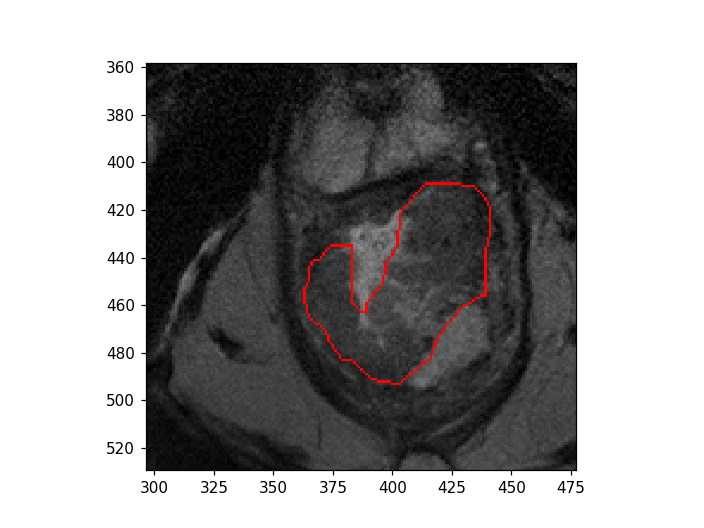

In [27]:
%matplotlib notebook
from matplotlib import pyplot as plt
im = imio.imread(os.path.join('/srv/gevaertlab/data/pritam_CRC_test/example_images_png/pre','0034_15.png'))
plt.imshow(im)

In [8]:
time = 'pre'
root = '/srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_'+time
import imageio as imio
import numpy as np
import os
from matplotlib import pyplot as plt
import pydicom as dicom
def load_series(path,target):
    files = [f for f in os.listdir(path) if f.endswith('dcm')]
    #print(path,files)
    images = [dicom.read_file(os.path.join(path,f)) for f in files]
    for i in images:
        assert i[0x2001,0x1003].value - images[0][0x2001,0x1003].value < 0.01
        if (i[0x2001,0x1003].value - target)>0.01:
            print('wrong b-value : skipping patient ',p)
            print('target, read_value',target,i[0x2001,0x1003].value)
            return False
    return True

for p in os.listdir(root):
    if not load_series(os.path.join(root,p+'/b-800'),800):
        print(p)


wrong b-value : skipping patient  0026
target, read_value 800 1200.0
0026
wrong b-value : skipping patient  0027
target, read_value 800 1200.0
0027
wrong b-value : skipping patient  0028
target, read_value 800 1200.0
0028
wrong b-value : skipping patient  0031
target, read_value 800 1200.0
0031
wrong b-value : skipping patient  0032
target, read_value 800 1200.0
0032
wrong b-value : skipping patient  0033
target, read_value 800 1200.0
0033
wrong b-value : skipping patient  0034
target, read_value 800 1200.0
0034
wrong b-value : skipping patient  0035
target, read_value 800 1200.0
0035
wrong b-value : skipping patient  0037
target, read_value 800 1200.0
0037
wrong b-value : skipping patient  0038
target, read_value 800 1200.0
0038
wrong b-value : skipping patient  0039
target, read_value 800 1200.0
0039
wrong b-value : skipping patient  0040
target, read_value 800 1200.0
0040
wrong b-value : skipping patient  0041
target, read_value 800 1200.0
0041
wrong b-value : skipping patient  0042

In [27]:
import numpy as np
import os
import imageio as imio
import pydicom as dicom
time = 'post'
current_root = '/srv/gevaertlab/data/pritam_CRC_Data/UMCU_DWI_'+time
alternate_root = '/srv/gevaertlab/data/pritam_CRC_Data/dwi_validation_cohort/'+time+'_b800'
dest = '/srv/gevaertlab/data/pritam_CRC_Data/adc_difference_maps'
def load_series(path,target):
    files = [f for f in os.listdir(path) if f.endswith('dcm')]
    images = [dicom.read_file(os.path.join(path,f)) for f in files]
    for i in images:
        assert i[0x2001,0x1003].value - images[0][0x2001,0x1003].value < 0.01
        if (i[0x2001,0x1003].value - target)>0.01:
            print('wrong b-value : skipping patient ',p)
            print('target, read_value',target,i[0x2001,0x1003].value)
    images = sorted(images, key=lambda x: x.SliceLocation)
    pixel_data = [x.pixel_array for x in images]
    true_bval = images[0][0x2001,0x1003].value
    return np.stack(pixel_data,axis=0),true_bval,images[0].ImageOrientationPatient,images[0].ImagePositionPatient

    


for p in os.scandir(alternate_root):
    if not p.is_dir():
        continue
    p = p.name
    interpolated_dir = os.path.join(current_root,'{0:0=4}'.format(int(p)))
    interpolated_adc = np.load(os.path.join(interpolated_dir,'adc.npy'))
    b0_path = os.path.join(interpolated_dir,'b-0')
    b0_vol,true_bval1,orient1,pos1= load_series(b0_path,0.0)
    b800_path = os.path.join(alternate_root,p)
    b800_vol,true_bval2,orient2,pos2= load_series(b800_path,800.0)
    assert orient1 == orient2
    assert pos1 == pos2
    assert true_bval2 == 800
    b0_vol = b0_vol.astype(np.float32)
    b800_vol = b800_vol.astype(np.float32)
    if (b0_vol.shape != b800_vol.shape):
        print('wrong shape: skipping patient',p)
        continue
    b0_vol[np.where(b0_vol == 0)] = 0.1
    b800_vol[np.where(b800_vol ==0)] =0.1
    adc_map = (-1/(true_bval2-true_bval1))*np.log(b800_vol/b0_vol) 
    adc_diff = np.absolute(adc_map - interpolated_adc)
    relative_diff=np.zeros_like(adc_diff)
    relative_diff[np.where(adc_diff!=0)] = adc_diff[np.where(adc_diff!=0)]/np.maximum(np.absolute(adc_map[np.where(adc_diff!=0)]),np.absolute(interpolated_adc[np.where(adc_diff!=0)]))
    #print(adc_diff.mean(),adc_diff.std())
    current_dest = os.path.join(dest,time)
#     img = (adc_diff - adc_map.min())/(adc_map.max()-adc_map.min())
#     img[img>1]=1
#     img[img<0]=0
#     print(img.mean(),adc_diff.max(),adc_diff.mean(),adc_diff.min())
    print(relative_diff.mean())
    if not os.path.exists(current_dest):
        os.makedirs(current_dest)
    imio.mimwrite(os.path.join(current_dest,p+'.gif'),[relative_diff[i,...] for i in range(relative_diff.shape[0])])
    print('finished processing patient {}'.format(p))


0.35071558


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9991041421890259]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.998293161392212]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9981056451797485]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.998792052268982]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.

finished processing patient 21
0.2988021


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9994326829910278]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.996610164642334]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.999052882194519]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9971314668655396]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.

finished processing patient 25
0.35377494


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9993350505828857]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9984949827194214]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9997031688690186]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9988101720809937]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python

finished processing patient 26
0.34874678


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9969968795776367]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9977442026138306]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.997873306274414]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9998897314071655]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3

finished processing patient 27
0.3706408


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.997043251991272]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.995186686515808]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.995686411857605]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9964072704315186]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6

finished processing patient 28
0.37069452


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9958982467651367]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9979225397109985]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9961367845535278]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9970005750656128]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python

finished processing patient 31
0.28913647


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.998462438583374]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9958901405334473]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9969855546951294]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 32
0.31967768


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9983751773834229]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 33
0.3882608


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9984561204910278]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9999492168426514]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9997849464416504]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9994865655899048]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 34
0.349326


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9996706247329712]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9982365369796753]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.999811053276062]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 35
0.23181629


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9979827404022217]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9966099262237549]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.995118498802185]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 37
0.26805595


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.994879961013794]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 38
0.37922338


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9997025728225708]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.999964952468872]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.999946117401123]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.999566674232483]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6

finished processing patient 39
0.28609183


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9964454174041748]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 40
0.4115941


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9994441270828247]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9996850490570068]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9981372356414795]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9996258020401]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6

finished processing patient 41
0.244154


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9986438751220703]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9992001056671143]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9995791912078857]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 42
0.30816993


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9989774227142334]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9990830421447754]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9995561838150024]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9994796514511108]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python

finished processing patient 43
0.25482413


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9998008012771606]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 44
0.23472258
finished processing patient 45
0.2824455


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9985322952270508]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.999163269996643]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 46
0.30830133


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9981986284255981]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9995335340499878]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9999221563339233]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9997254610061646]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python

finished processing patient 47
0.25924453


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9981921911239624]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9994518756866455]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9990612268447876]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 48
0.17079121


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.999602198600769]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9943578243255615]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9898234605789185]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.995167851448059]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.

finished processing patient 58
0.20407684


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.995439887046814]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9983181953430176]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9967930316925049]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9966809749603271]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3

finished processing patient 59
0.16877633


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9966120719909668]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9980024099349976]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9970227479934692]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9943941831588745]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 60
0.22918472
finished processing patient 64
0.17528504


/home/pritamm/miniconda3/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float32 to uint8, range [0.0, 1.9921807050704956]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


finished processing patient 65


In [3]:
import os
import pydicom as dicom
import numpy as np
import pandas as pd
import datetime
from multiprocessing import Pool
from matplotlib import path
import imageio as imio
from matplotlib import colors as color
from scipy.io import savemat
from scipy.ndimage import map_coordinates

In [47]:
def get_transform_matrix(sorted_images):
    N = len(sorted_images)
    if N<2:
        return None
    T1 = np.array(sorted_images[0].ImagePositionPatient).astype(np.float32)
    TN = np.array(sorted_images[len(sorted_images)-1].ImagePositionPatient).astype(np.float32)
    cosines = sorted_images[0].ImageOrientationPatient
    delta_r = sorted_images[0].PixelSpacing[0]
    delta_c = sorted_images[0].PixelSpacing[1]
    F = np.array([[cosines[3],cosines[0]],[cosines[4],cosines[1]],[cosines[5],cosines[2]]])
    transform = np.zeros([4,4])
    transform[0:3,0]= F[:,0]*delta_r
    transform[0:3,1] = F[:,1]*delta_c
    transform[0:3,2] = ((T1-TN)/(1-N)).T
    transform[0:3,3] = T1.T
    transform[3,3]=1
    return transform

def load_series(path):
    files = [f for f in os.listdir(path) if f.endswith('dcm')]
    images = [dicom.read_file(os.path.join(path,f)) for f in files]
    i=0
    roi_struct = None
    while i<len(images):
        if images[i].SOPClassUID == '1.2.840.10008.5.1.4.1.1.481.3':
            roi_struct = images.pop(i)
            i-=1
        i+=1
    images = sorted(images, key=lambda x: x.SliceLocation)
    return images, roi_struct

def load_pixel_vol(vol,axis):
    return np.stack([image.pixel_array for image in vol],axis=axis)

def align_vols(t2_vol, dwi_vol, adc_vol, dwi_transform):
    t2_transform = get_transform_matrix(t2_vol)
    t2_pixel_vol = load_pixel_vol(t2_vol,2)
    t2_coords = np.array(np.where(t2_pixel_vol>=0))
    t2_coords_in_dwi_frame = np.dot( np.linalg.inv(dwi_transform)@ t2_transform ,np.vstack([t2_coords,np.ones([1,t2_coords.shape[1]])]))[0:3,:] 
    interpolated_adc_vol = map_coordinates(adc_vol,t2_coords_in_dwi_frame,order =1,mode='constant',cval=0)
    transformed_adc_vol = np.reshape(interpolated_adc_vol,t2_pixel_vol.shape)
    interpolated_dwi_vol = map_coordinates(dwi_vol,t2_coords_in_dwi_frame,order =1,mode='constant',cval=0)
    transformed_dwi_vol = np.reshape(interpolated_dwi_vol,t2_pixel_vol.shape)
    return transformed_dwi_vol, transformed_adc_vol

def transform_coords(t_matrix,coords):
    concat_coord = np.concatenate((coords,np.ones([coords.shape[0],1])),axis =1)
    new_coords = np.dot(t_matrix,concat_coord.T)
    return new_coords[0:3,:]

def get_roi_info(mask_info):
    #mask_info = dicom.read_file(roi_file)
    contour_dict = {}
    for i in range(len(mask_info.ROIContourSequence)):
        contour_dict['ROIContourSequence'+str(i)] = {}
        for j in range(len(mask_info.ROIContourSequence[i].ContourSequence)):
            contour_data = mask_info.ROIContourSequence[i].ContourSequence[j].ContourData
            coords = [[contour_data[3*i],contour_data[3*i+1],contour_data[3*i+2]] for i in range(int(len(contour_data)/3))] 
            sop_uid = mask_info.ROIContourSequence[i].ContourSequence[j].ContourImageSequence[0].ReferencedSOPInstanceUID
            contour_dict['ROIContourSequence'+str(i)][sop_uid] = coords
    return contour_dict

def process_contours(contour_dict,ref_vol):
#    print('Trying alternate process contours for patient:', ref_vol[0].PatientName)
    voxel_2_world = get_transform_matrix(ref_vol)
    x_len = ref_vol[0].pixel_array.shape[0]
    y_len = ref_vol[0].pixel_array.shape[1]
    z_len = len(ref_vol)
    slice_grid = np.array(np.where(np.zeros([x_len,y_len])==0)).T
    new_vol = np.zeros([ref_vol[0].pixel_array.shape[0],ref_vol[0].pixel_array.shape[1],len(ref_vol)])
    contour_points = []
    for roi_contour_seq in contour_dict:
        for sop_id in contour_dict[roi_contour_seq]:
            coords = np.array(contour_dict[roi_contour_seq][sop_id])
            roi_t2_pixel_coords = transform_coords(np.linalg.inv(voxel_2_world),coords)
            #print(roi_t2_pixel_coords.shape)
            slice_to_process = np.unique(np.round(roi_t2_pixel_coords[2:]).astype(np.int32))
#            print(slice_to_process)
            if slice_to_process.shape[0]>1:
                print('Slices to process:', slice_to_process)
                return None
            contour_path = path.Path(roi_t2_pixel_coords[0:2,:].T,closed=True)
            contour_points.append(roi_t2_pixel_coords)
            new_slice = np.zeros([x_len,y_len,1])
            points_included = slice_grid[np.where(contour_path.contains_points(slice_grid))]
            new_slice[points_included[:,0],points_included[:,1],np.zeros_like(points_included[:,1])]=1
#            print(new_slice.shape, new_vol[:,:,slice_to_process].shape)
            new_vol[:,:,slice_to_process]=new_slice
    #print(np.concatenate(contour_points,axis=0).shape)
    return new_vol,contour_points

def save_vol(vol,dest):
    if not os.path.exists(os.path.dirname(dest)):
        os.makedirs(os.path.dirname(dest))
    savemat(dest,{'img':vol})

def get_spacing(dicom_vol):
    return np.array([dicom_vol[0].PixelSpacing[0],dicom_vol[0].PixelSpacing[1],dicom_vol[0].SliceThickness])

def process_patient_time(inputs):
    patient = inputs[0]
    time = inputs[1]
    t2_path,dwi0_path,dwi800_path = sourcepaths[(patient,time)]
    try:
        t2_vol,roi_struct = load_series(t2_path)
    except FileNotFoundError:
        print('Not found patient {} with time {}'.format(patient,time))
        return
    dwi0_vol,_ = load_series(dwi0_path)
    dwi800_vol,_ = load_series(dwi800_path)
    dwi800_pixel_vol = load_pixel_vol(dwi800_vol,2)
    dwi0_pixel_vol = load_pixel_vol(dwi0_vol,2)
    dwi800_pixel_vol = dwi800_pixel_vol.astype(np.float32)
    dwi0_pixel_vol = dwi0_pixel_vol.astype(np.float32)
    dwi800_pixel_vol[dwi800_pixel_vol<0.1]=0.1
    dwi0_pixel_vol[dwi0_pixel_vol<0.1]=0.1
    adc_map = (-1/(800))*np.log(dwi800_pixel_vol/dwi0_pixel_vol) 
    dwi800_pixel_vol = load_pixel_vol(dwi800_vol,2)
    dwi_transform = get_transform_matrix(dwi0_vol)
    t2_pixel_vol = load_pixel_vol(t2_vol,2)
    transformed_dwi_vol, transformed_adc_vol = align_vols(t2_vol,dwi800_pixel_vol,adc_map,dwi_transform)
    roi_contour = get_roi_info(roi_struct)
    mask,_ = process_contours(roi_contour,t2_vol)
    spacings = get_spacing(t2_vol)
    t2_dest = os.path.join(dest,'processed_t2'+'/'+time+'/'+str(patient)+'.mat')
    dwi_dest = os.path.join(dest,'processed_dwi'+'/'+time+'/'+str(patient)+'.mat')
    adc_dest = os.path.join(dest,'processed_adc'+'/'+time+'/'+str(patient)+'.mat')
    mask_dest = os.path.join(dest,'processed_mask'+'/'+time+'/'+str(patient)+'.mat')
    spacings_dest = os.path.join(dest,'processed_spacings'+'/'+time+'/'+str(patient)+'.mat')
    save_vol(t2_pixel_vol,t2_dest)
    save_vol(transformed_dwi_vol,dwi_dest)
    save_vol(transformed_adc_vol,adc_dest)
    save_vol(mask,mask_dest)
    save_vol(spacings,spacings_dest)
    print('Finished processing patient {} for time {}'.format(patient,time))
    


In [48]:
times = ['pre','post']
dest = '/srv/gevaertlab/data/pritam_CRC_Data/validation_feature_extraction'
t2_root = '/srv/gevaertlab/data/CRC_Data/CRC_Validation_T2'
t2_missing = '/srv/gevaertlab/data/pritam_CRC_Data/missing_t2_validation'
dwi_root = '/srv/gevaertlab/data/pritam_CRC_Data/'
t2_time = {'pre':'T2_time1/umcu_data','post':'T2_time2/umcudata'}


def get_t2_path(patient,time):
    path = os.path.join(t2_root,t2_time[time]+'/{0:04}'.format(patient)+'/dicom')
    if not os.path.exists(path):
        path = os.path.join(t2_missing,'{0:04}'.format(patient)+'/dicom')
    return path

patients = [int(x) for x in os.listdir(os.path.join(dwi_root,'UMCU_DWI_pre'))]
sourcepaths ={}
for patient in patients:
    for time in times:
        t2_path = get_t2_path(patient,time)
        dwi0_path = os.path.join(dwi_root,'UMCU_DWI_{0}/{1:04}/b-0'.format(time,patient))        
        default_b800_path = os.path.join(dwi_root,'dwi_validation_cohort/{0}_b800/{1}'.format(time,patient))
        alternate_b800_path = os.path.join(dwi_root,'UMCU_DWI_{0}/{1:04}/b-800'.format(time,patient))
        if os.path.exists(default_b800_path):
            dwi800_path = default_b800_path
        elif os.path.exists(alternate_b800_path):
            dwi800_path = alternate_b800_path
        else:
            print('Weird double check {0},{1!s}'.format(time,patient))
        sourcepaths[(patient,time)]=[t2_path,dwi0_path,dwi800_path]
        


In [50]:
from multiprocessing import Pool
inputs = [(patient,time) for patient in patients for time in times]
with Pool(10) as pool:
    pool.map(process_patient_time,inputs)

Finished processing patient 3 for time post
Finished processing patient 13 for time pre
Finished processing patient 2 for time pre
Finished processing patient 8 for time post
Finished processing patient 10 for time pre
Finished processing patient 16 for time pre
Finished processing patient 14 for time post
Finished processing patient 17 for time post
Finished processing patient 7 for time pre
Finished processing patient 11 for time post
Finished processing patient 4 for time pre
Finished processing patient 2 for time post
Finished processing patient 13 for time post
Finished processing patient 10 for time post
Finished processing patient 7 for time post
Finished processing patient 16 for time post
Finished processing patient 9 for time pre
Finished processing patient 15 for time pre
Finished processing patient 18 for time pre
Finished processing patient 12 for time pre
Finished processing patient 3 for time pre
Finished processing patient 8 for time pre
Finished processing patient 17 f

In [49]:
process_patient_time((10,'post'))

Finished processing patient 10 for time post
